Version 1/2  - one basic  model 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'pretrained-models', 'pytorch-pretrained-models']


In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
from PIL import Image
from tqdm import tqdm_notebook
import torchvision
from torch.autograd import Variable



import sys
package_dir = "../input/pretrained-models/pretrained-models/pretrained-models.pytorch-master/"
sys.path.insert(0, package_dir)

import pretrainedmodels

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import argparse


import numpy as np
import pandas as pd
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import tqdm 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from tqdm._tqdm_notebook import tqdm_notebook
plt.ion()   # interactive mode
tqdm_notebook.pandas()

#from apex import amp

## Global Variables 
global variables definitions 

In [3]:
IMAGE_SIZE = 256 
SEED = 1234
PATH = "../input/aptos2019-blindness-detection/train_images"
EPOCH = 25
NUM_MODEL = 1

### Read Meta Data 

In [4]:
image_ids = pd.read_csv("../input//aptos2019-blindness-detection/train.csv") 
image_ids.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## Show image example

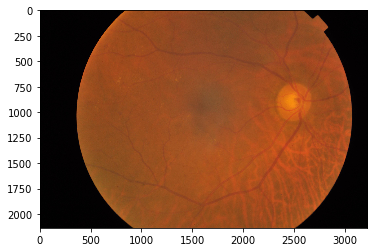

In [5]:
random.seed(SEED)
id = random.choice(os.listdir(PATH))
id_code = id.split(".")[0]
image = np.asarray(Image.open(os.path.join(PATH, id)))
plt.imshow(image)  
plt.show()

## Random Seed 

In [6]:
def seed_all(seed= SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Image Pre Process 

In [7]:
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_image(path, id_code, size):
    img_path = path
    image = Image.open(img_path)
    image = image.resize((size, size), resample=Image.BILINEAR)
    #image_arr = image.reshape( size,size, 3).astype('float32')
    #print(image_arr.shape)
    return image

### Image Data Loader class 

In [8]:
class ImageDataLoader(torch.utils.data.Dataset):

    def __init__(self,train_file,root_dir,size =256,transform=None):
        """
        Args:
            train_file(string): path to train file (meta data )
            root_dir(string): directory with all train images
        """
        self.root_dir = root_dir
        self.size = size
        self.name_frame = train_file['id_code'].values
        self.label_frame = train_file['diagnosis'].values
        self.transform = transform
        

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        
       
       
        img_name = os.path.join(self.root_dir, self.name_frame[idx]+str(".png"))
        image = get_image(img_name, idx, self.size)
        label = self.label_frame[idx]
        
          
              
        
        if self.transform:
            image = self.transform(image);
            
        
      
        
        return {'image': image,
                'labels': label
                }
        
        
        

## Pre Process 

In [9]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        #return torch.from_numpy(image).float()
        return transforms.ToTensor(image)
    
    

### Split Data 

In [10]:
train , val =  train_test_split(image_ids ,test_size=0.1, random_state=SEED)
train_index = list(train.index)
val_index = list(val.index)

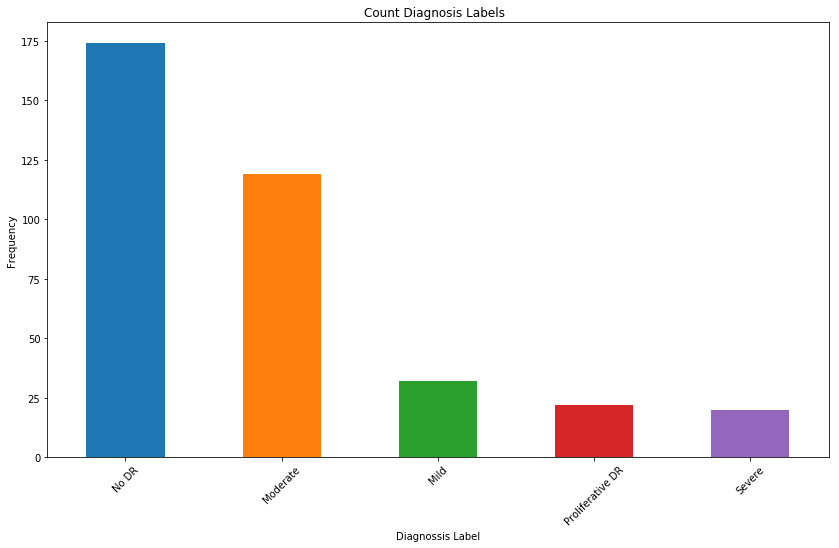

In [11]:
ax = val['diagnosis'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Count Diagnosis Labels  ")
ax.set_xlabel("Diagnossis Label")
ax.set_ylabel("Frequency")
ax.set_xticklabels( labels = list(('No DR', 'Moderate', 'Mild', 'Proliferative DR', 'Severe')),rotation=45)
plt.show()

### Data Loader 
Create Train and Validation loader 

In [12]:
batch_size = 16

transform_ori = transforms.Compose([transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    


TrainSet = ImageDataLoader(train_file = train,root_dir = "../input//aptos2019-blindness-detection/train_images/",size=256,transform = transform_ori)
                                  

                                       
ValidSet = ImageDataLoader(train_file = val,root_dir = "../input//aptos2019-blindness-detection/train_images/",size=256,transform = transform_ori)
                                


TrainLoader = torch.utils.data.DataLoader(TrainSet,batch_size=batch_size,shuffle=True, num_workers=4)
ValidLoader = torch.utils.data.DataLoader(ValidSet,batch_size=batch_size,shuffle=True, num_workers=4)



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    
    

## Pre Trained  Model 

In [14]:
#model = torchvision.models.resnet101(pretrained=False)
model = pretrainedmodels.__dict__['resnet101'](pretrained=None)
#model.load_state_dict(torch.load("../input/pytorch-pretrained-models/resnet101-5d3b4d8f.pth"))

model.avg_pool = nn.AdaptiveAvgPool2d(1)
model.last_linear = nn.Sequential(
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.25),
                          nn.Linear(in_features=2048, out_features=2048, bias=True),
                          nn.ReLU(),
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.5),
                          nn.Linear(in_features=2048, out_features=1, bias=True),
                         )




model = model.to(device)


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [16]:
plist = [
         {'params': model.layer4.parameters(), 'lr': 1e-3, 'weight': 0.001}]

optimizer = optim.Adam(plist, lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)

In [17]:
child_counter= 0
for child in model.children():
    if child_counter < 8:
        print("child ",child_counter," was frozen")
        for param in child.parameters():
            param.requires_grad = False


    child_counter +=1
    

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was frozen
child  6  was frozen
child  7  was frozen


In [18]:
since = time.time()
criterion = nn.MSELoss()
num_epochs = EPOCH
 



for num_model in range (NUM_MODEL):
    
    

    
    
    seed = SEED+num_model*3
    seed_all(seed)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        scheduler.step()
        model.train()
        running_loss = 0.0
        tk0 = tqdm_notebook(TrainLoader, total=int(len(TrainLoader)))
        counter = 0
        for i, items in enumerate(tk0):
            inputs = items["image"]
            labels = items["labels"].view(-1, 1)
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                #loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            counter += 1
            tk0.set_postfix(loss=(running_loss / (counter * batch_size)))
        epoch_loss = running_loss / (len(TrainLoader) * batch_size)
        print('Training Loss: {:.4f}'.format(epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    torch.save(model.state_dict(), "modelResnet101Seed"+str(seed) +".bin")
    

Epoch 0/24
----------



Training Loss: 3.1079
Epoch 1/24
----------



Training Loss: 3.1276
Epoch 2/24
----------



Training Loss: 3.1229
Epoch 3/24
----------



Training Loss: 3.1811
Epoch 4/24
----------



Training Loss: 3.1690
Epoch 5/24
----------



Training Loss: 3.1556
Epoch 6/24
----------



Training Loss: 3.1438
Epoch 7/24
----------



Training Loss: 3.1880
Epoch 8/24
----------



Training Loss: 3.1776
Epoch 9/24
----------



Training Loss: 3.1738
Epoch 10/24
----------



Training Loss: 3.1228
Epoch 11/24
----------



Training Loss: 3.1528
Epoch 12/24
----------



Training Loss: 3.1720
Epoch 13/24
----------



Training Loss: 3.1491
Epoch 14/24
----------



Training Loss: 3.1763
Epoch 15/24
----------



Training Loss: 3.1613
Epoch 16/24
----------



Training Loss: 3.1724
Epoch 17/24
----------


##  Creating Submission

In [19]:
class RetinopathyDatasetTest(Dataset):
    def __init__(self, csv_file, transform):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join('../input/aptos2019-blindness-detection/test_images', self.data.loc[idx, 'id_code'] + '.png')
        image = Image.open(img_name)
        image = self.transform(image)
        return {'image': image}

In [20]:
model.load_state_dict(torch.load("modelResnet101Seed"+str(seed) +".bin"))
model = model.to(device)

In [21]:
for param in model.parameters():
    param.requires_grad = False

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [22]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = RetinopathyDatasetTest(csv_file='../input/aptos2019-blindness-detection/sample_submission.csv',
                                      transform=test_transform)

In [23]:
for j in range(10):
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    vars()["test_preds"+str(j)] = np.zeros((len(test_dataset), 1))
    tk0 = tqdm_notebook(test_data_loader)
    for i, x_batch in enumerate(tk0):
        x_batch = x_batch["image"]
        pred = model(x_batch.to(device))
        vars()["test_preds"+str(j)][i * 32:(i + 1) * 32] = pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)

In [24]:
test_preds = (test_preds0 +test_preds1 + test_preds2 + test_preds3 + test_preds4 + test_preds5
             + test_preds6 + test_preds7 + test_preds8 + test_preds9 ) / 10.0

In [25]:
coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(test_preds):
    if pred < coef[0]:
        test_preds[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_preds[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_preds[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_preds[i] = 3
    else:
        test_preds[i] = 4


sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
sample.diagnosis = test_preds.astype(int)
sample.to_csv("submission.csv", index=False)
sample.diagnosis


0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       1
9       0
10      0
11      0
12      0
13      0
14      1
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1898    0
1899    0
1900    1
1901    0
1902    0
1903    0
1904    0
1905    0
1906    0
1907    1
1908    0
1909    0
1910    0
1911    0
1912    0
1913    0
1914    0
1915    0
1916    1
1917    0
1918    0
1919    0
1920    0
1921    0
1922    0
1923    0
1924    0
1925    0
1926    0
1927    0
Name: diagnosis, Length: 1928, dtype: int64